1. Install

In [ ]:
# Installiere das Mamba-SSM Paket inkl.
# Verhindere, dass pip Abhängigkeiten nachlädt und baue direkt gegen das Colab-PyTorch
!pip install --no-deps --no-build-isolation mamba-ssm[causal-conv1d]



2. Test Mamaba and Pytorch Setup

In [ ]:
import torch
from mamba_ssm.modules.mamba_simple import Mamba

# Gerät wählen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("PyTorch-Version:", torch.__version__)

# Einen Mamba-Block instanziieren
d_model, d_state, d_conv, expand = 32, 16, 4, 2
block = Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand).to(device)

# Testeingabe: Batch=8, Sequenzlänge=50, Feature-Dim=d_model
x = torch.randn(8, 50, d_model, device=device)
y = block(x)

print("Input shape :", x.shape)
print("Output shape:", y.shape)  # sollte (8, 50, d_model) sein


Device: cuda
PyTorch-Version: 2.6.0+cu124
Input shape : torch.Size([8, 50, 32])
Output shape: torch.Size([8, 50, 32])


3. Data Loading

In [ ]:
# 3. Daten laden, bereinigen, Feature-Scaling, Split & DataLoader einrichten (mit datetime-Prints)

import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch

# ——— Parameter ———
HIST_LEN   = 24
FORE_LEN   = 24
BATCH_SIZE = 16

# 3.1 CSV laden & nach datetime sortieren
df_raw = pd.read_csv('merged_data.csv', parse_dates=['datetime'])
df_raw = df_raw.sort_values('datetime').reset_index(drop=True)

# datetime separat speichern
all_dates = df_raw['datetime'].copy().reset_index(drop=True)

# 3.2 'datetime' löschen und alle NA-Zeilen entfernen
df = df_raw.drop(columns=['datetime']).dropna().reset_index(drop=True)

# 3.3 Spalten definieren
target_col     = 'price_EUR_MWh'
hist_feat_cols = [c for c in df.columns if c != target_col]
forecast_cols  = ['temperature_2m', 'wind_speed_180m', 'wind_speed_120m', 'direct_radiation']

# 3.4 Feature-Scaling
scaler_hist  = StandardScaler()
scaler_fore  = StandardScaler()
scaler_price = StandardScaler()

df[hist_feat_cols] = scaler_hist.fit_transform(df[hist_feat_cols])
df[forecast_cols]  = scaler_fore.fit_transform(df[forecast_cols])
df[[target_col]]   = scaler_price.fit_transform(df[[target_col]])

# 3.5 Zeit-Split (80/20)
split_idx   = int(len(df) * 0.8)
train_df    = df.iloc[:split_idx].reset_index(drop=True)
val_df      = df.iloc[split_idx:].reset_index(drop=True)
train_dates = all_dates.iloc[:split_idx].reset_index(drop=True)
val_dates   = all_dates.iloc[split_idx:].reset_index(drop=True)

# 3.6 Dataset-Klasse mit Rückskalierung und vollständigen Zeit- & Feature-Prints
class PriceDataset(Dataset):
    def __init__(self, df, dates, hist_len, fore_len, scaler_hist, scaler_fore):
        self.X_hist      = torch.from_numpy(df[hist_feat_cols].values).float()
        self.X_fore      = torch.from_numpy(df[forecast_cols].values).float()
        self.y           = torch.from_numpy(df[target_col].values).float()
        self.dates       = dates
        self.hist_len    = hist_len
        self.fore_len    = fore_len
        self.scaler_hist = scaler_hist
        self.scaler_fore = scaler_fore

    def __len__(self):
        return len(self.X_hist) - self.hist_len - self.fore_len + 1

    def __getitem__(self, idx):
        i1 = idx + self.hist_len
        i2 = i1 + self.fore_len

        hist_seq = self.X_hist[idx:i1]
        fore_seq = self.X_fore[i1:i2]
        target   = self.y[i1:i2].unsqueeze(-1)

        # Debug-Print für die ersten 3 Fenster, rückskaliert
        if idx < 3:
            hist_times = self.dates[idx:i1].tolist()
            fore_times = self.dates[i1:i2].tolist()
            # Tensor → NumPy → inverse scale
            hist_np = hist_seq.numpy()
            fore_np = fore_seq.numpy()
            hist_orig = self.scaler_hist.inverse_transform(hist_np)
            fore_orig = self.scaler_fore.inverse_transform(fore_np)

            #print(f"--- Window idx={idx} ---")
            #print(f" History from {hist_times[0]} to {hist_times[-1]}")
            #print(" hist_seq ORIGINAL (first 3 rows):")
            #for row in hist_orig[:3]:
            #    print("   ", row.tolist())
            #print(" hist_seq ORIGINAL (last 3 rows):")
            #for row in hist_orig[-3:]:
             #   print("   ", row.tolist())
            #print(f" Forecast from {fore_times[0]} to {fore_times[-1]}")
            #print(" fore_seq ORIGINAL (first 3 rows):")
            #for row in fore_orig[:3]:
            #    print("   ", row.tolist())
            #print(" fore_seq ORIGINAL (last 3 rows):")
            #for row in fore_orig[-3:]:
            #    print("   ", row.tolist())
            #print(f" target (scaled) shape = {target.shape}")
            #print("---------------------------")

        return hist_seq, fore_seq, target

# 3.7 DataLoader instanziieren mit Scalern übergeben
train_ds     = PriceDataset(train_df, train_dates, HIST_LEN, FORE_LEN, scaler_hist, scaler_fore)
val_ds       = PriceDataset(val_df,   val_dates,   HIST_LEN, FORE_LEN, scaler_hist, scaler_fore)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

#print(f"Train-Sequenzen: {len(train_ds)}, Validation-Sequenzen: {len(val_ds)}")

# 3.8 Quick-Check auf NaNs im Batch
batch = next(iter(train_loader))
x_h, x_f, y_t = batch
print("Any NaNs in x_hist, x_fore, y? →",
      x_h.isnan().any().item(), x_f.isnan().any().item(), y_t.isnan().any().item())


Any NaNs in x_hist, x_fore, y? → False False False


4. Modell Definition

In [ ]:
# 4. Modelldefinition mit Summary-Injection, Dropout+LayerNorm und optimiertem AdamW

import torch
import torch.nn as nn
from mamba_ssm.modules.mamba_simple import Mamba

class Encoder(nn.Module):
    def __init__(self, n_hist_feats, d_model, d_state, d_conv, expand, n_layers, p_dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(n_hist_feats, d_model)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand),
                nn.Dropout(p_dropout),
                nn.LayerNorm(d_model)
            )
            for _ in range(n_layers)
        ])
    def forward(self, x):
        # x: [B, T_hist, n_hist_feats]
        h = self.input_proj(x)               # → [B, T_hist, d_model]
        for blk in self.blocks:
            h = blk(h)                       # → [B, T_hist, d_model]
        return h[:, -1]                      # → [B, d_model] (Zusammenfassung)

class Decoder(nn.Module):
    def __init__(self, n_fore_feats, d_model, d_state, d_conv, expand, n_layers, p_dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(n_fore_feats + d_model, d_model)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand),
                nn.Dropout(p_dropout),
                nn.LayerNorm(d_model)
            )
            for _ in range(n_layers)
        ])
        self.head = nn.Linear(d_model, 1)

    def forward(self, x_fore, enc_state):
        # x_fore:    [B, T_fore, n_fore_feats]
        # enc_state: [B, d_model]
        B, T, _ = x_fore.size()

        # 1) Encoder-State über Zeitschritte ausbreiten
        s_exp = enc_state.unsqueeze(1).expand(-1, T, -1)   # [B, T, d_model]
        # 2) Feature-Kombi
        inp = torch.cat([x_fore, s_exp], dim=-1)           # [B, T, n_fore + d_model]
        h   = self.input_proj(inp)                         # [B, T, d_model]

        # 3) Full-Sequence SSM-Blöcke
        for blk in self.blocks:
            h = blk(h)                                     # [B, T, d_model]

        # 4) Preis-Kopf
        return self.head(h)                                # [B, T, 1]

class PricePredictor(nn.Module):
    def __init__(self,
                 n_hist_feats, n_fore_feats,
                 d_model=32, d_state=16, d_conv=4, expand=2, n_layers=3, p_dropout=0.1):
        super().__init__()
        self.encoder = Encoder(n_hist_feats, d_model, d_state, d_conv, expand, n_layers, p_dropout)
        self.decoder = Decoder(n_fore_feats, d_model, d_state, d_conv, expand, n_layers, p_dropout)

    def forward(self, x_hist, x_fore):
        s = self.encoder(x_hist)          # → [B, d_model]
        y = self.decoder(x_fore, s)       # → [B, T_fore, 1]
        return y

# 4.1 Modul instanziieren & Sanity-Check
n_hist_feats = len(hist_feat_cols)
n_fore_feats = len(forecast_cols)
model = PricePredictor(n_hist_feats, n_fore_feats).to(device)

# 4.2 Optimizer mit getrennten Weight-Decay-Gruppen & Huber-Loss
criterion = nn.SmoothL1Loss()

# Parametergruppen: kein decay für bias/LayerNorm
decay, no_decay = [], []
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if 'bias' in name or 'norm' in name or 'LayerNorm' in name:
        no_decay.append(param)
    else:
        decay.append(param)

optimizer = torch.optim.AdamW(
    [
        {'params': decay,    'weight_decay': 1e-5},
        {'params': no_decay, 'weight_decay': 0.0}
    ],
    lr=1e-4
)

# 4.3 Sanity-Check: Forward auf einem Batch
batch = next(iter(train_loader))
x_hist, x_fore, y_true = [t.to(device) for t in batch]
y_pred = model(x_hist, x_fore)
print(f"y_pred shape: {y_pred.shape}   (→ [BATCH_SIZE, FORE_LEN, 1])")


y_pred shape: torch.Size([4, 168, 1])   (→ [BATCH_SIZE, FORE_LEN, 1])


5. Training und Validation

In [ ]:
# 5. Trainings-Loop mit LR-Scheduler & Early Stopping (ohne Shuffle)

import time
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import no_grad

# ——— Hyperparameter ———
EPOCHS    = 50
PATIENCE  = 10     # Abbruch nach 5 Epochen ohne Val-Verbesserung
CLIP_NORM = 1.0

# ——— LR-Scheduler nach Optimizer definieren ———
# (setzt automatisch die LR herab, wenn Val-Loss für `patience` Epochen stagniert)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

best_val_loss = float('inf')
stale_epochs  = 0

for epoch in range(1, EPOCHS+1):
    start = time.time()

    # ——— Training ———
    model.train()
    train_loss = 0.0
    for x_hist, x_fore, y_true in train_loader:
        x_hist, x_fore, y_true = x_hist.to(device), x_fore.to(device), y_true.to(device)

        optimizer.zero_grad()
        y_pred = model(x_hist, x_fore)                     # [B, T_fore, 1]

        # 1) Huber/MSE-Loss
        mse_loss = criterion(y_pred, y_true)
        # 2) Derivative-Loss (Form-Strafe)
        deriv_loss = F.mse_loss(
            y_pred[:,1:] - y_pred[:,:-1],
            y_true[:,1:]  - y_true[:,:-1]
        )
        # 3) Gesamt-Loss mit Gewicht 0.5 auf die Form-Strafe
        loss = mse_loss + 0.5 * deriv_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()

        train_loss += loss.item() * x_hist.size(0)
    train_loss /= len(train_loader.dataset)

    # ——— Validation ———
    model.eval()
    val_loss = 0.0
    with no_grad():
        for x_hist, x_fore, y_true in val_loader:
            x_hist, x_fore, y_true = x_hist.to(device), x_fore.to(device), y_true.to(device)
            y_pred = model(x_hist, x_fore)

            mse_loss   = criterion(y_pred, y_true)
            deriv_loss = F.mse_loss(
                y_pred[:,1:] - y_pred[:,:-1],
                y_true[:,1:]  - y_true[:,:-1]
            )
            loss = mse_loss + 0.5 * deriv_loss
            val_loss += loss.item() * x_hist.size(0)
    val_loss /= len(val_loader.dataset)

    # ——— Scheduler updaten mit Val-Loss ———
    scheduler.step(val_loss)

    # ——— Early-Stopping Logic ———
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        stale_epochs  = 0
    else:
        stale_epochs += 1
        if stale_epochs >= PATIENCE:
            print(f"→ Early stopping at epoch {epoch} (no val-improve in {PATIENCE} epochs)")
            break

    print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | {time.time()-start:4.1f}s")


Epoch  1 | Train Loss: 0.0926 | Val Loss: 0.2027 | 85.3s
Epoch  2 | Train Loss: 0.0893 | Val Loss: 0.2079 | 84.7s
Epoch  3 | Train Loss: 0.0875 | Val Loss: 0.2181 | 84.7s
Epoch  4 | Train Loss: 0.0857 | Val Loss: 0.2128 | 84.6s
Epoch  5 | Train Loss: 0.0844 | Val Loss: 0.2116 | 84.6s
Epoch  6 | Train Loss: 0.1003 | Val Loss: 0.1861 | 85.6s
Epoch  7 | Train Loss: 0.1030 | Val Loss: 0.1780 | 84.8s
Epoch  8 | Train Loss: 0.0988 | Val Loss: 0.1704 | 84.9s
Epoch  9 | Train Loss: 0.0989 | Val Loss: 0.1644 | 84.6s
Epoch 10 | Train Loss: 0.0957 | Val Loss: 0.1569 | 84.9s
Epoch 11 | Train Loss: 0.0947 | Val Loss: 0.1518 | 84.7s
Epoch 12 | Train Loss: 0.0930 | Val Loss: 0.1532 | 84.5s
Epoch 13 | Train Loss: 0.0897 | Val Loss: 0.1495 | 84.8s
Epoch 14 | Train Loss: 0.0895 | Val Loss: 0.1473 | 84.8s
Epoch 15 | Train Loss: 0.0887 | Val Loss: 0.1489 | 84.6s
Epoch 16 | Train Loss: 0.0867 | Val Loss: 0.1465 | 84.7s
Epoch 17 | Train Loss: 0.0855 | Val Loss: 0.1447 | 84.9s
Epoch 18 | Train Loss: 0.0854 |

Saving the model

In [ ]:
# Pfad zum Speichern
MODEL_PATH = "Endec11n15b4price_predictor.pth"
SCALER_PATH = "Endec11n15b4scalers.pkl"

# 1) Modell speichern
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model weights saved to {MODEL_PATH}")

# 2) Optional: Deine Scaler auch speichern (damit du später korrekt inverse-transformieren kannst)
import pickle
with open(SCALER_PATH, "wb") as f:
    pickle.dump({
        "scaler_hist": scaler_hist,
        "scaler_fore": scaler_fore,
        "scaler_price": scaler_price
    }, f)
print(f"Scalers saved to {SCALER_PATH}")


Model weights saved to Endec11n15b4price_predictor.pth
Scalers saved to Endec11n15b4scalers.pkl


Download locally

In [ ]:
from google.colab import files
files.download('/content/Endec11n15b4price_predictor.pth')
files.download('/content/Endec11n15b4scalers.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plots seven day forecast

plot val

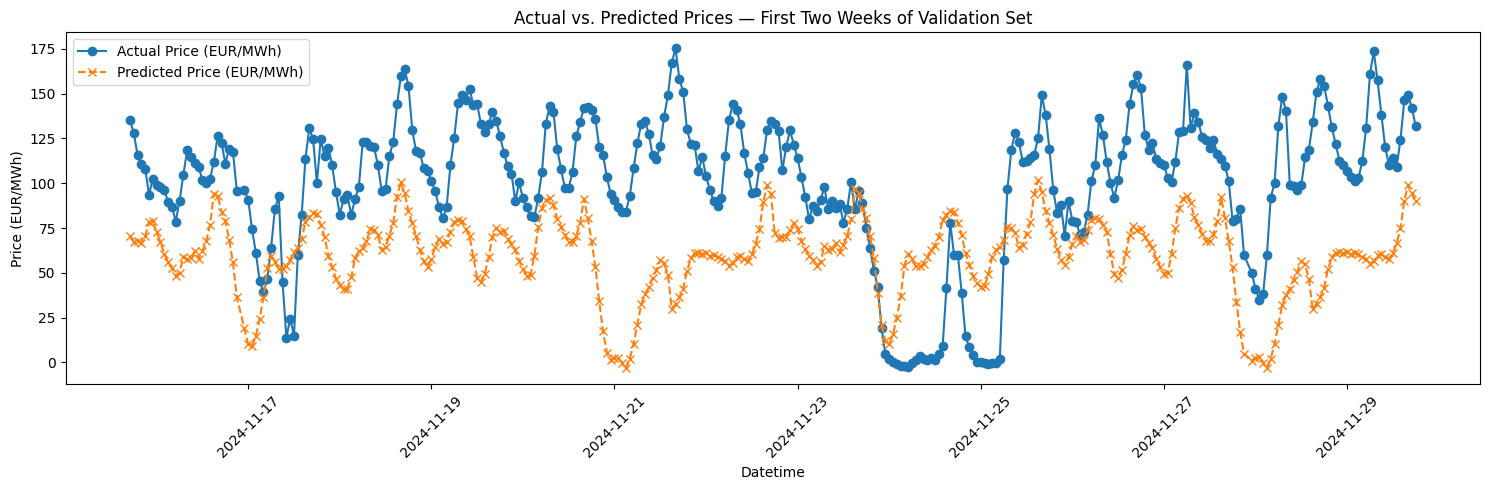

In [ ]:
# 8. Plot the first two weeks of actual validation prices + model predictions

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1) Load and sort the CSV (same as before)
orig_df = (
    pd.read_csv('merged_data.csv', parse_dates=['datetime'])
      .sort_values('datetime')
      .reset_index(drop=True)
      .dropna(subset=['price_EUR_MWh'])
)

# 2) Train/Val split
split_idx = int(len(orig_df) * 0.8)
val_orig  = orig_df.iloc[split_idx:].reset_index(drop=True)

# 3) Select first two weeks (14 days × 24 hours)
hours_2w = 14 * 24
dt_2w    = val_orig['datetime'].iloc[:hours_2w]
pr_2w    = val_orig['price_EUR_MWh'].iloc[:hours_2w]

# ——————————————————————————————————————————————
# now compute your model’s predictions for exactly that same period

model.eval()
all_preds = []
with torch.no_grad():
    for x_hist, x_fore, y_true in val_loader:
        # forward-pass
        y_pred = model(x_hist.to(device), x_fore.to(device))
        # flatten and collect
        all_preds.append(y_pred.cpu().numpy().reshape(-1))

# concatenate and inverse-transform
preds_flat = np.concatenate(all_preds)
preds_inv  = scaler_price.inverse_transform(preds_flat.reshape(-1,1)).flatten()

# grab exactly the first two weeks
pred_2w = preds_inv[:hours_2w]

# 4) Plot both actual and predicted
plt.figure(figsize=(15,5))
plt.plot(dt_2w, pr_2w,   marker='o', linestyle='-', label='Actual Price (EUR/MWh)')
plt.plot(dt_2w, pred_2w, marker='x', linestyle='--', label='Predicted Price (EUR/MWh)')
plt.title('Actual vs. Predicted Prices — First Two Weeks of Validation Set')
plt.xlabel('Datetime')
plt.ylabel('Price (EUR/MWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


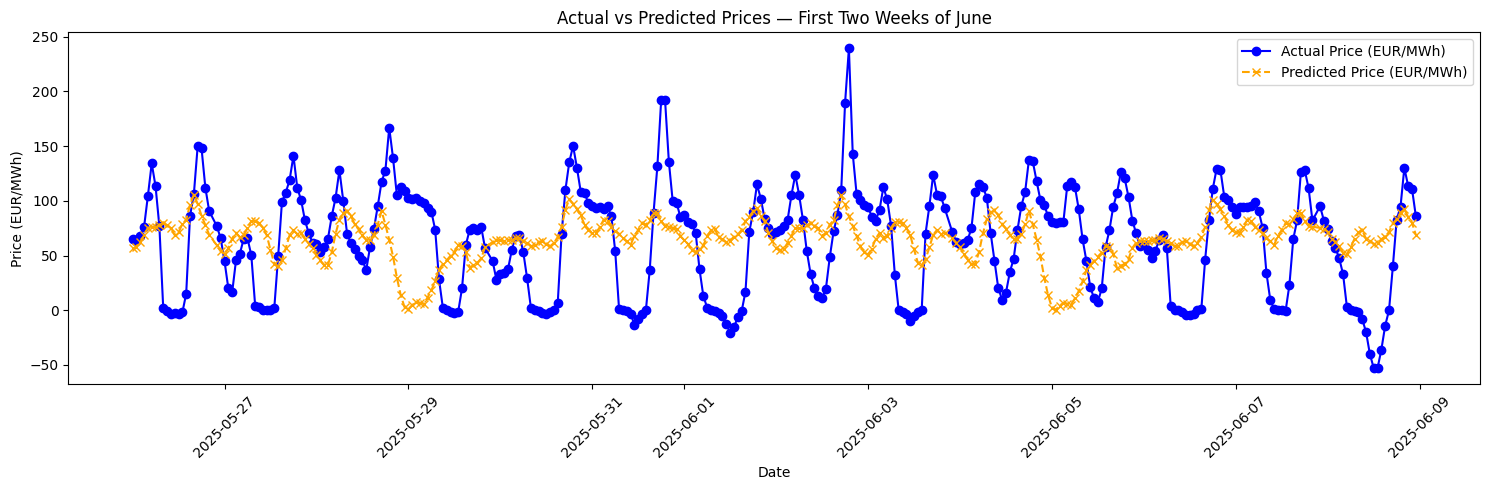

In [ ]:
# 8. Plot the first two weeks of June - actual validation prices + model predictions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1) Load and sort the CSV (same as before)
orig_df = pd.read_csv('merged_data.csv', parse_dates=['datetime'])
orig_df = orig_df.sort_values('datetime').reset_index(drop=True)
orig_df = orig_df.dropna(subset=['price_EUR_MWh'])

# 2) Train/val split
split_idx = int(len(orig_df) * 0.8)
val_orig = orig_df.iloc[split_idx:].reset_index(drop=True)

# 3) Select first two weeks of June (weeks 22 and 23)
val_orig['datetime'] = pd.to_datetime(val_orig['datetime'])
mask = val_orig['datetime'].dt.isocalendar().week.isin([22, 23])

# 4) Compute model predictions over the entire validation set
model.eval()
all_preds = []
with torch.no_grad():
    for batch in val_loader:
        x_hist = batch[0].to(device)
        x_fore = batch[1].to(device)
        y_pred = model(x_hist, x_fore)
        all_preds.append(y_pred.cpu().numpy().reshape(-1))

preds_flat = np.concatenate(all_preds)
preds_inv = scaler_price.inverse_transform(preds_flat.reshape(-1,1)).flatten()

# 5) Extract predictions for June weeks only - WICHTIG: Erst die Längen anpassen!
# Stelle sicher, dass preds_inv die gleiche Länge wie val_orig hat
if len(preds_inv) > len(val_orig):
    preds_inv = preds_inv[:len(val_orig)]  # Schneide überschüssige Vorhersagen ab

pred_sel = preds_inv[mask]  # Verwende mask ohne .values
pr_sel = val_orig.loc[mask, 'price_EUR_MWh'].values
dt_sel = val_orig.loc[mask, 'datetime'].values

# 6) Plot
plt.figure(figsize=(15,5))
plt.plot(dt_sel, pr_sel, marker='o', linestyle='-', label='Actual Price (EUR/MWh)', color='blue')
plt.plot(dt_sel, pred_sel, marker='x', linestyle='--', label='Predicted Price (EUR/MWh)', color='orange')
plt.title('Actual vs Predicted Prices — First Two Weeks of June')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()